# Application d'analyse des données de Formule 1 saison 2022
celle que je peux récupérer en tout cas

Cette application est réutilisable pour les prochaines saisons

## Imports

In [12]:
%matplotlib inline
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json

## Backend
dans cette partie, je fais tous ce qui ne relève pas de l'affichage des graphs.
Cela permet d'avoir directement toutes les données d'un coup pour ensuite juste avoir a
choisir le graph a afficher

In [13]:
# import data
data_speed = pd.read_csv('data/race_avg_speed.csv', sep=",")
data_points = pd.read_csv('data/race_points.csv', sep=",")
data_times = pd.read_csv('data/race_time.csv', sep=",")
data_best_lap = pd.read_csv('data/race_best_lap.csv', sep=",")
data_grid = pd.read_csv("data/race_grid.csv", sep=",")
data_result = pd.read_csv("data/race_result.csv")

X = [i for i in range(1, data_points.shape[0]+1)]
n = 6
order = ["ham","rus","ver","per","lec","sai","gas","tsu","ric","nor","oco","alo","vet","str","lat","alb","bot","zho","mag","sch"]
colors = {
    "ham": "#00AA88",
    "rus": "#3C9E8C",
    "ver": "#0000FF",
    "per": "#00006E",
    "lec": "#FF0000",
    "sai": "#5E0101",
    "gas": "#555555",
    "tsu": "#999999",
    "ric": "#FF8C00",
    "nor": "#BA7827",
    "oco": "#FF8AFF",
    "alo": "#C75BC7",
    "vet": "#27542B",
    "str": "#1D9929",
    "lat": "#697DFF",
    "alb": "#293587",
    "bot": "#FF00A2",
    "zho": "#AB006C",
    "mag": "#5C0099",
    "sch": "#9900FF"
}

jsonfile = open("teams.json")
teams_pilot = json.load(jsonfile)

pdata = pd.concat([data_result, data_points, data_grid, data_speed, data_times, data_best_lap])
        


## Frontend
Ici les affichages seront séparé pour pouvoir choisir ce qu'on affiche

### Test data import

        ham       rus     ver      per       lec       sai      gas       tsu  \
0     3.000     4.000   19.00   18.000     1.000     2.000   20.000     8.000   
0    15.000    12.000    0.00    0.000    26.000    18.000    0.000     4.000   
0     5.000     9.000    2.00    4.000     1.000     3.000   10.000    16.000   
0   202.469   202.313  204.14  202.762   206.018   203.501  200.189   200.642   
0  5863.259  5864.795     NaN      NaN  5853.584  5859.182      NaN  5873.970   
0    96.228    96.302   95.44   96.089    94.570    95.740   97.324    97.104   

        ric       nor  ...       alo       vet       str       lat       alb  \
0    14.000    15.000  ...     9.000    12.000    16.000    13.000     6.000   
0     0.000     0.000  ...     2.000     0.000     0.000     0.000     8.000   
0    18.000    13.000  ...     8.000    19.000    20.000    14.000     6.000   
0   200.318   200.882  ...   201.412   200.555   198.300   200.125   201.691   
0  5908.559  5909.919  ...  5875

<AxesSubplot:>

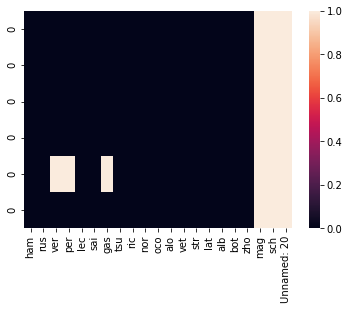

In [26]:
print(data_result)
print(data_points)
print(data_times)
print(data_best_lap)
print(data_grid)

print(pilots_data)
print(pdata)
sns.heatmap(pdata.isna())

print(teams_pilot)

### nuage de point
un graph avec la position sur la grille en x, et le classement en y. cela permet de predire si l'ordre de la grille est conservé

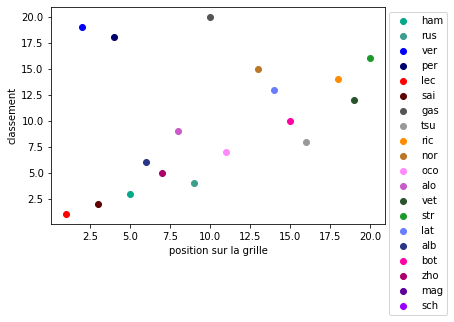

In [23]:
for pilot in order:
    plt.scatter(data_grid[pilot], data_result[pilot], color=colors[pilot], label=pilot)
plt.xlabel("position sur la grille")
plt.ylabel("classement")
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))

toujours un nuage de point, mais avec les temps totaux en x et temps du meilleur tour en y

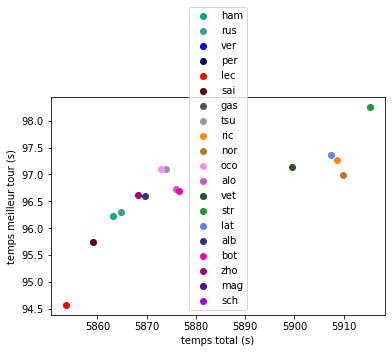

In [10]:
for pilot in order:
    plt.scatter(data_times[pilot], data_best_lap[pilot], color=colors[pilot], label=pilot)
plt.xlabel("temps total (s)")
plt.ylabel("temps meilleur tour (s)")
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))